In [1]:
import pickle
import pandas as pd
from sklearn.utils import resample
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from comparers import LogisticRegressionVsXGBComparer, make_path, X, y, display_data
import shap
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
notebook_name = 'Classic SHAP'

In [2]:
%matplotlib inline

In [3]:
comparer = LogisticRegressionVsXGBComparer()
comparer.load_or_train()

Loaded model: models/LogisticRegressionModel.pickle
Loaded model: models/XGBModel.json


Reduce dataset to be explained from 32561 to 1000 samples:

In [4]:
X, y, display_data = resample(X, y, display_data, n_samples=1000, replace=False, stratify=y, random_state=0)

In [5]:
masker = shap.maskers.Independent(X, max_samples=100)

In [6]:
def generate_explanation(model, filename):
    explainer = shap.Explainer(model, masker)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    with open(filename, 'wb') as f:
        pickle.dump((explainer, shap_values), f)
    return explainer, shap_values
        
def load_or_generate_explanation(model, filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return generate_explanation(model, filename)

In [7]:
explainer_a, shap_values_a = load_or_generate_explanation(
    comparer.model_a.predict_proba,
    make_path(f'{notebook_name}.a'))

Permutation explainer: 1001it [00:30, 22.63it/s]                          


In [8]:
explainer_b, shap_values_b = load_or_generate_explanation(
    comparer.model_b.predict_proba,
    make_path(f'{notebook_name}.b'))

Permutation explainer: 1001it [00:29, 22.29it/s]                         


## Scatter plots
They are generalizations of the partial dependence plots.

With the parameter color, we instruct SHAP to pick the feature that has the biggest interaction effects with the explained feature and to colour the observations according to its' shapeley values.

In [9]:
def scatter_plot(feature_name):
    printmd(f'### {feature_name}')
    shap.plots.scatter(shap_values_a[:,feature_name], color=shap_values_a)
    shap.plots.scatter(shap_values_b[:,feature_name], color=shap_values_b)

### Age

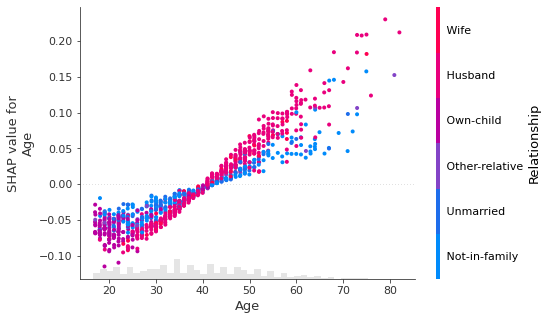

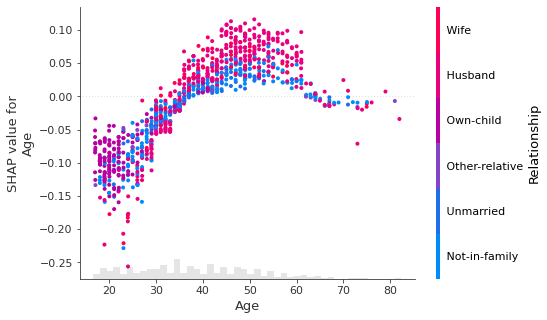

### Workclass

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


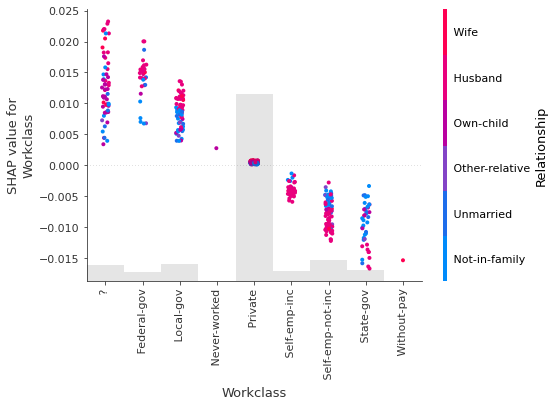

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


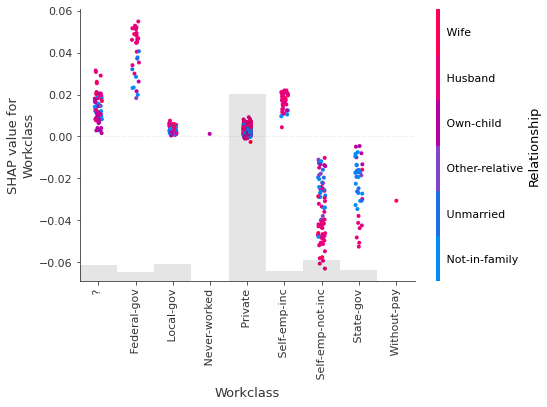

### Education-Num

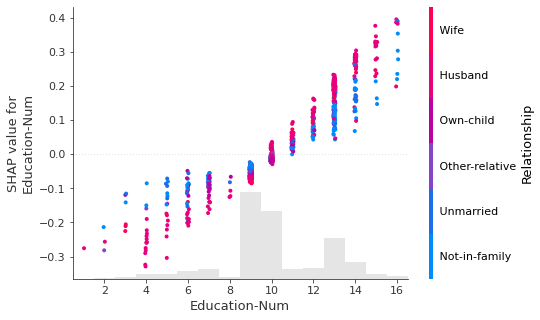

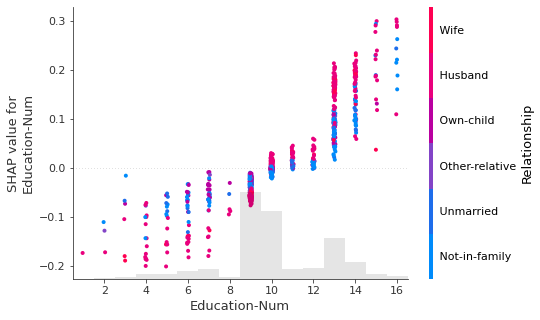

### Marital Status

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


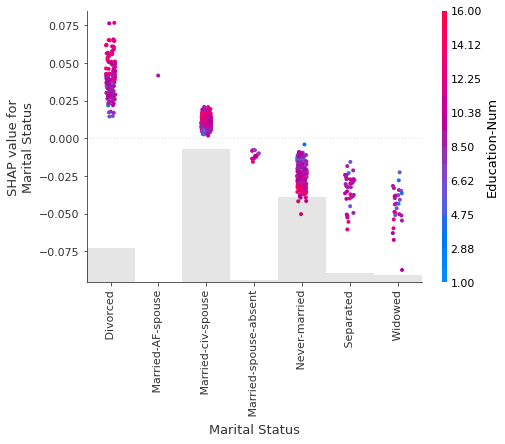

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


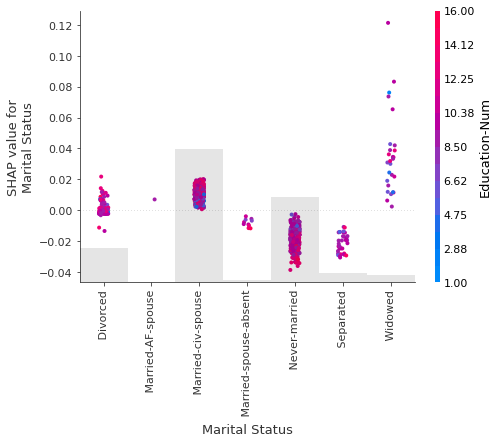

### Occupation

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


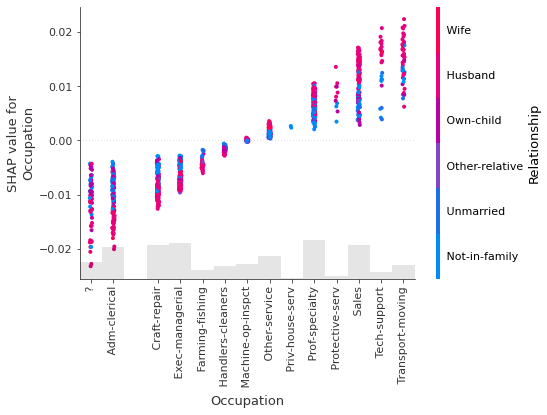

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


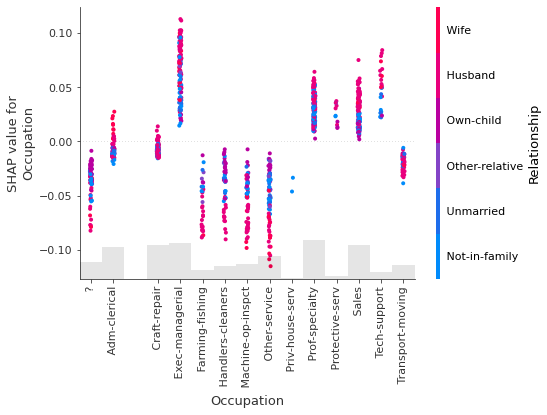

### Relationship

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


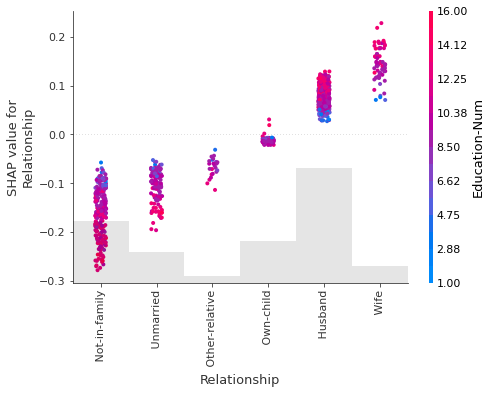

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


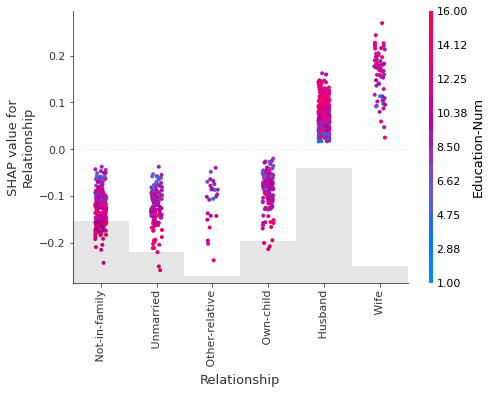

### Race

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


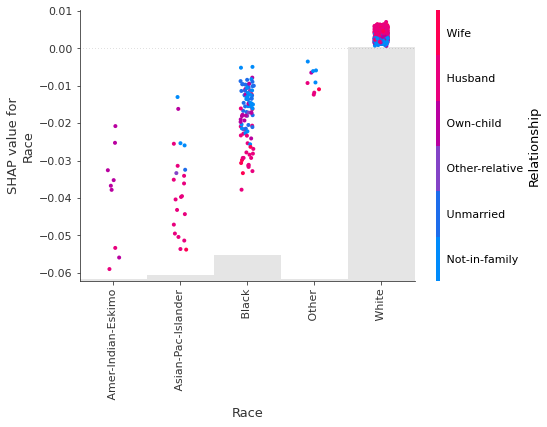

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


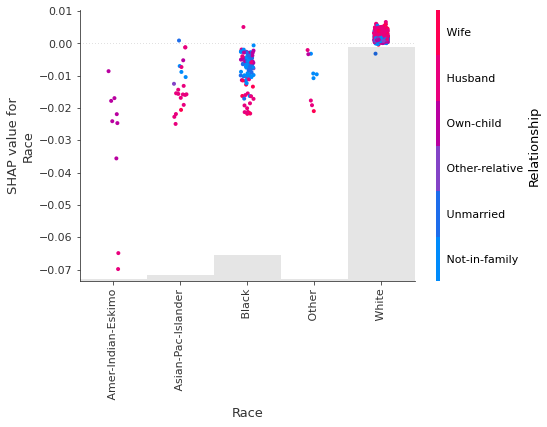

### Sex

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


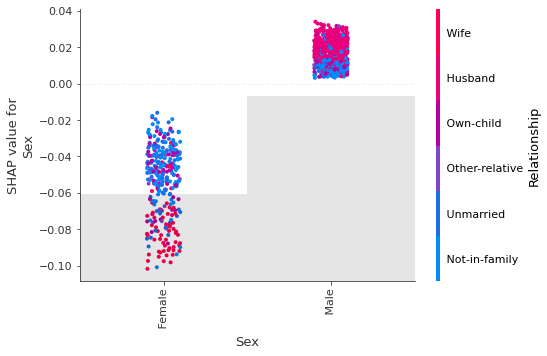

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


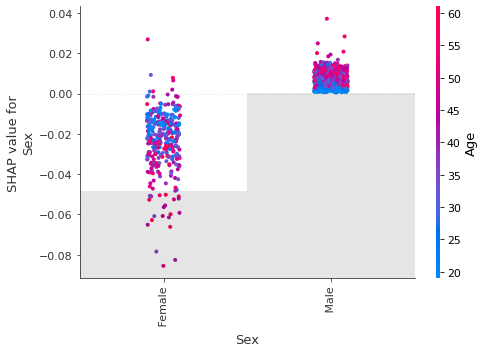

### Capital Gain

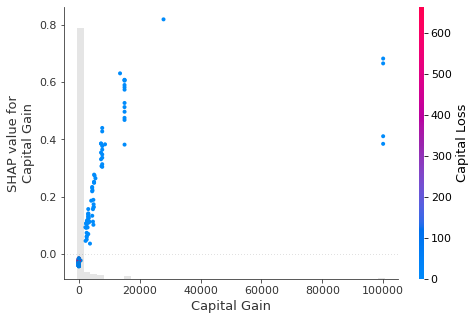

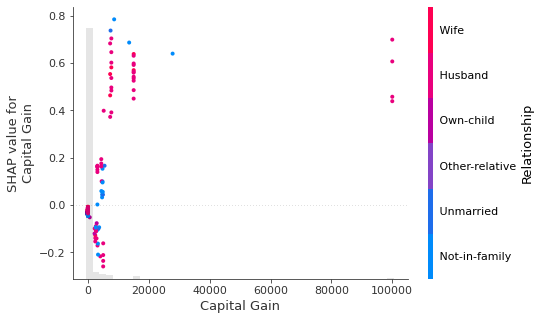

### Capital Loss

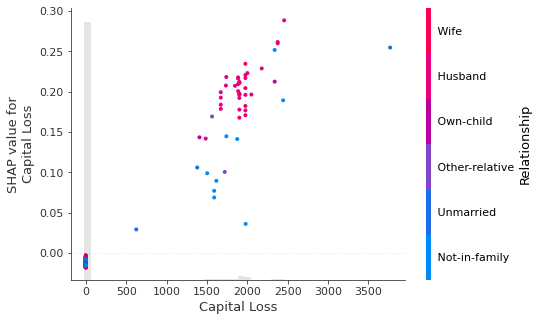

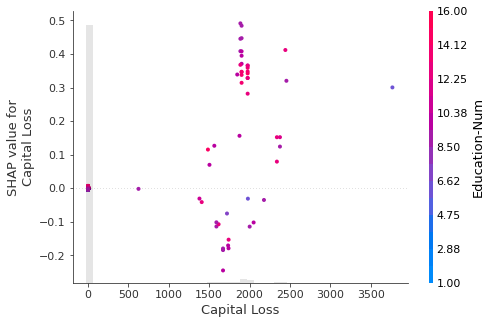

### Hours per week

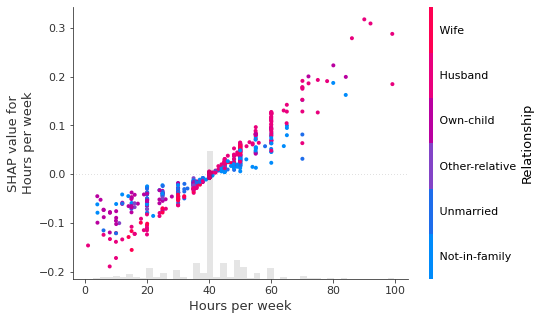

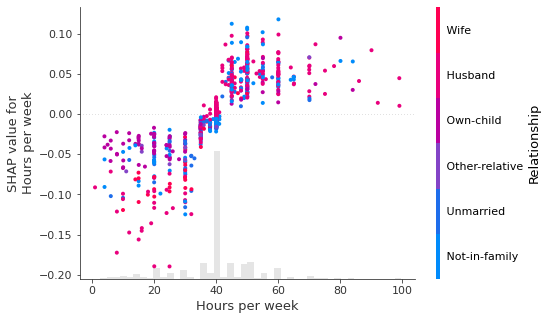

### Country

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


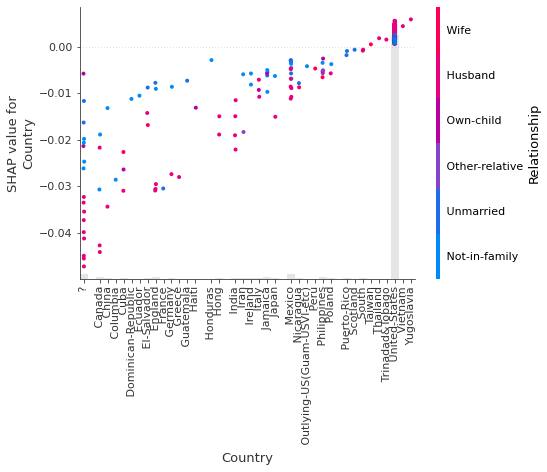

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


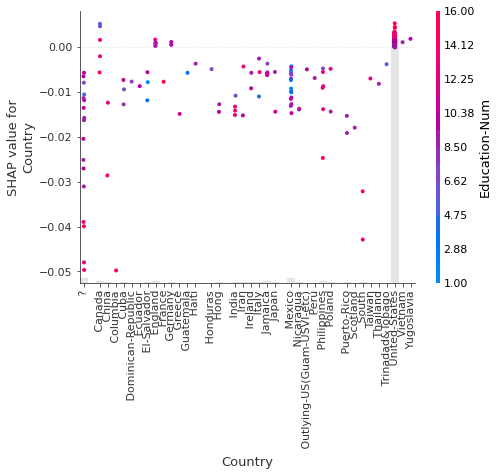

In [10]:
for feature_name in X.columns:
    scatter_plot(feature_name)

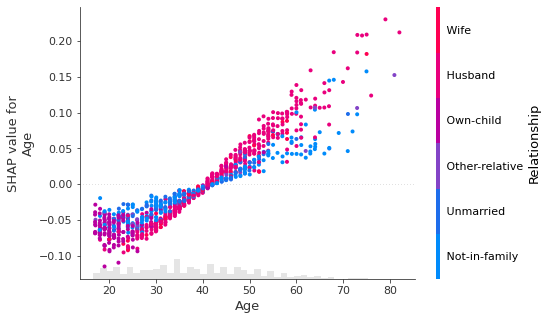

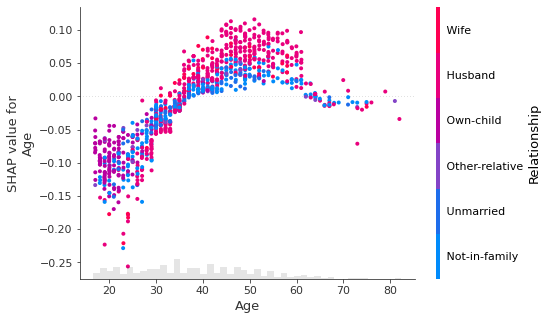

In [11]:
shap.plots.scatter(shap_values_a[:,"Age"], color=shap_values_a)
shap.plots.scatter(shap_values_b[:,"Age"], color=shap_values_b)

Notice the strong interaction effect in the plots of model A. Logistic regression is better explained using the log of odds instead of probabilities.

## Bar plots
> By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

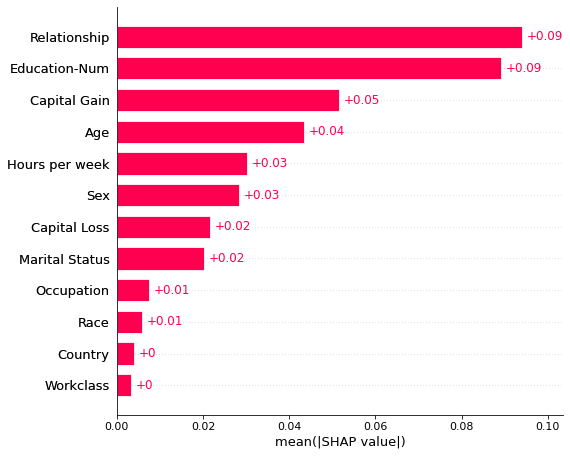

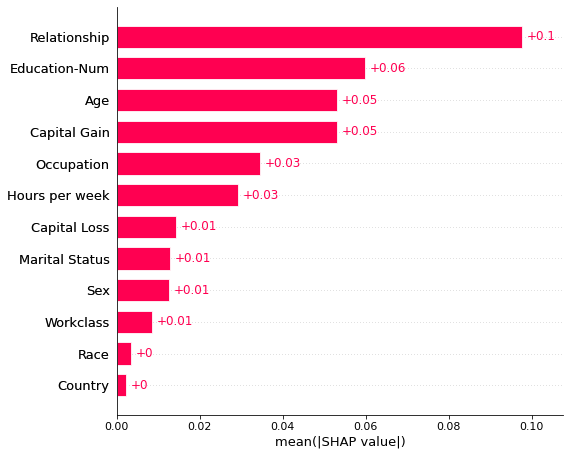

In [12]:
shap.plots.bar(shap_values_a, max_display=len(X.columns))
shap.plots.bar(shap_values_b, max_display=len(X.columns))

> But the mean absolute value is not the only way to create a global measure of feature importance, we can use any number of transforms. Here we show how using the max absolute value highights the Capital Gain and Capital Loss features, since they have infrewuent but high magnitude effects.

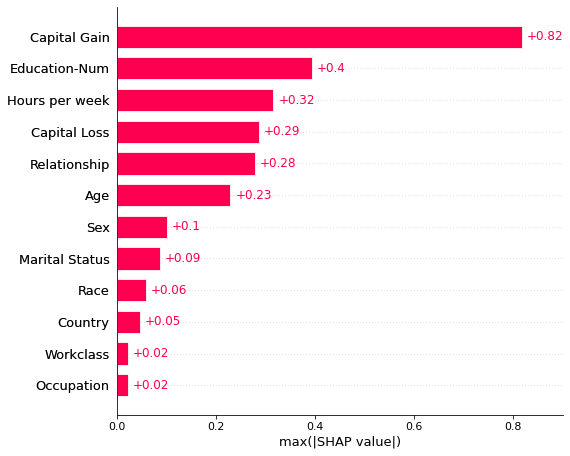

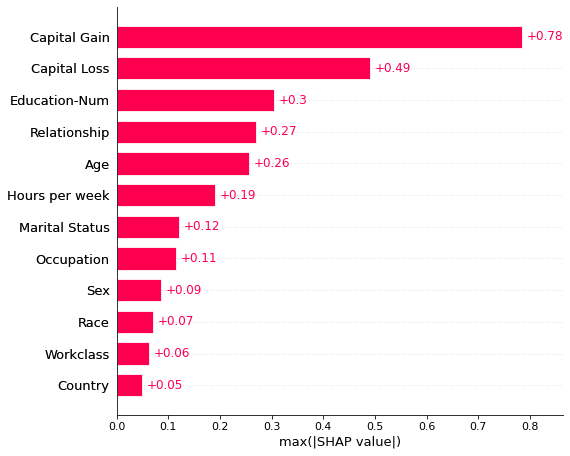

In [13]:
shap.plots.bar(shap_values_a.abs.max(0), max_display=len(X.columns))
shap.plots.bar(shap_values_b.abs.max(0), max_display=len(X.columns))

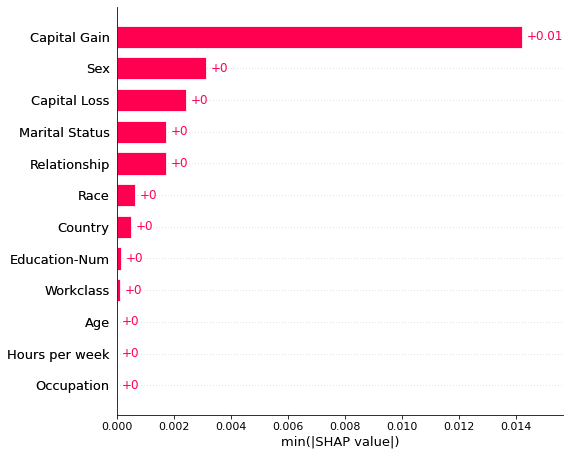

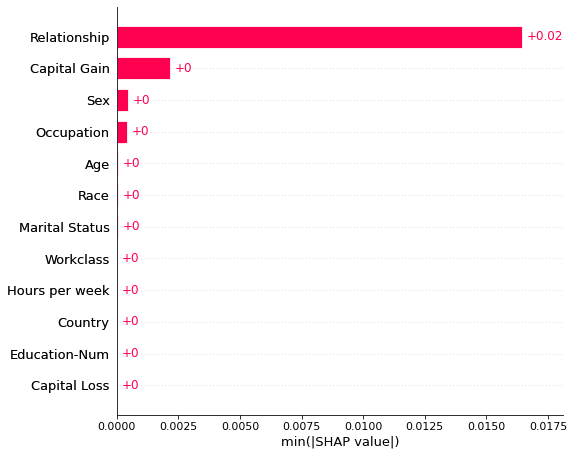

In [14]:
shap.plots.bar(shap_values_a.abs.min(0), max_display=len(X.columns))
shap.plots.bar(shap_values_b.abs.min(0), max_display=len(X.columns))

We can also compare feature importance for subsets separately, like for men and women:

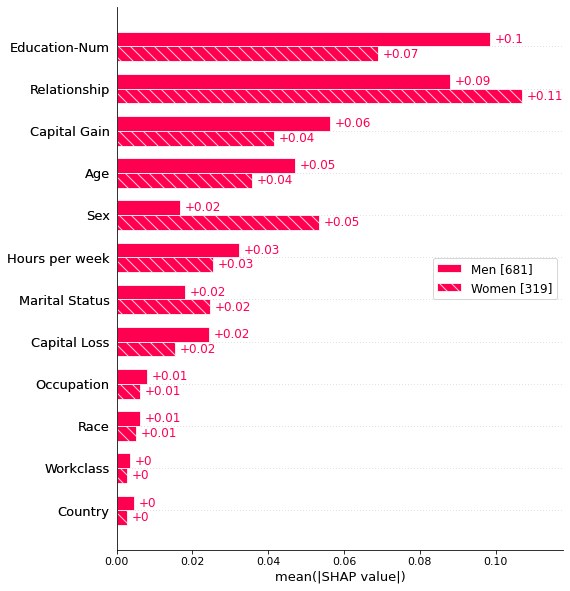

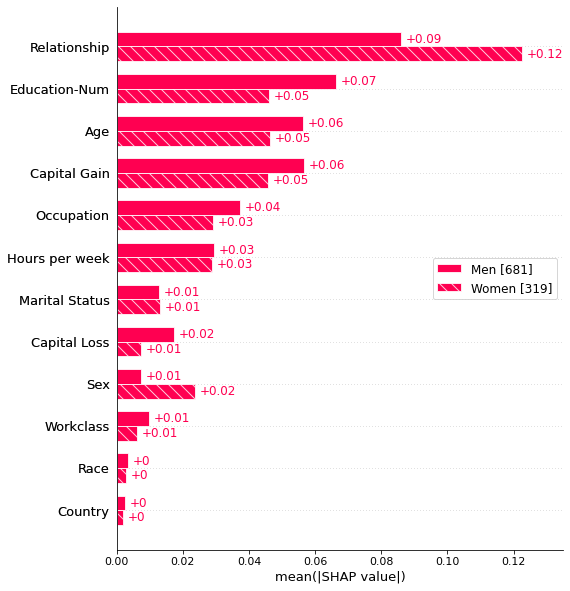

In [15]:
sex = ['Women' if shap_values_a[i, 'Sex'].data == 0 else 'Men' for i in range(shap_values_a.shape[0])]
shap.plots.bar(shap_values_a.cohorts(sex).abs.mean(0), max_display=12)
shap.plots.bar(shap_values_b.cohorts(sex).abs.mean(0), max_display=12)

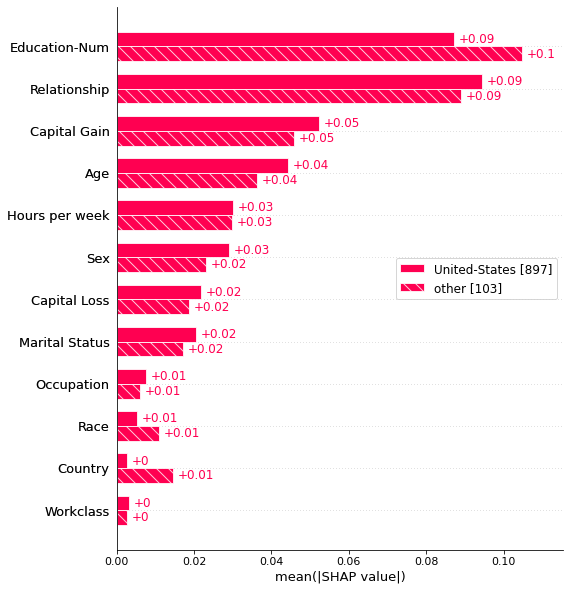

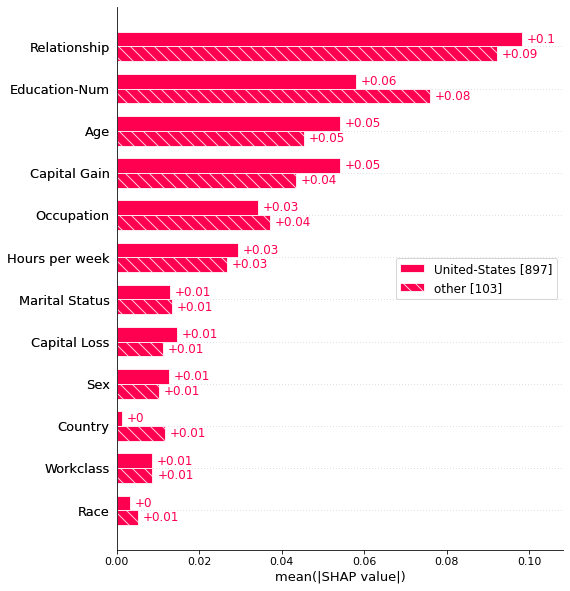

In [16]:
country = pd.DataFrame(display_data, columns=X.columns)['Country'].str.strip().map({'United-States': 'United-States'}).fillna('other').to_list()
shap.plots.bar(shap_values_a.cohorts(country).abs.mean(0), max_display=12)
shap.plots.bar(shap_values_b.cohorts(country).abs.mean(0), max_display=12)